In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

import sys
sys.path.append("../")
from bargains_linear import * 

In [2]:
seq_result = pd.read_csv('fake_data/seq_data.csv',index_col=0)
active_result = pd.read_csv('fake_data/active_data.csv',index_col=0)
passive_result = pd.read_csv('fake_data/passive_data.csv',index_col=0)


In [3]:
#calculate moment conditions for the linear model...
def solve_parameters_obj(data,params, active=False,seq=False):
    wtp,cost,beta1,beta2,mc1,mc2 = params
    
    data_moments = list(data.mean())
    phi1,phi2 = None,None
    if seq:
        phi1,phi2 = seq_bargain(25, cost, wtp, [mc1,mc2],betas=[beta1,beta2])
    elif active:
        phi1,phi2 = simult_bargain(25,25, cost, wtp, [mc1,mc2],active=True,betas=[beta1,beta2])
    else:
        phi1,phi2 = simult_bargain(25,25, cost, wtp, [mc1,mc2],active=False,betas=[beta1,beta2])
    
    phi1,phi2,p1,p2,s1,s2 = solve_eq(phi1,phi2,cost,wtp,[mc1,mc2])
    computed_moments = [phi1,phi2,p1,p2,s1,s2]
    
    obj = 0
    for i in range(6):
        obj = obj + (data_moments[i] - computed_moments[i])**2
    
    return obj
    

print( solve_parameters_obj(seq_result,[25,5,.5,.5,0,0], seq=True) )
print( solve_parameters_obj(seq_result,[25,5,.5,.5,0,0], active=True) )


print( solve_parameters_obj(active_result,[25,5,.5,.5,0,0], active=True) )
print( solve_parameters_obj(active_result,[25,5,.5,.5,0,0], seq=True) )


print( solve_parameters_obj(passive_result,[25,5,.5,.5,0,0], active=False) )
print( solve_parameters_obj(passive_result,[25,5,.5,.5,0,0], active=True) )

6.825327037529594
99.21292877249188
0.7859837821511065
78.56293164231437
0.04669038877599222
153.5668905075749


In [4]:
def solve_parameters(data,active=False,seq=False): 
    obj = lambda params: solve_parameters_obj(data,params,active=active,seq=seq)
    params = minimize(obj, [25,5,.5,.5,0,0], options={'fatol':1e-6,'xatol':1e-6,'maxiter':20},method='Nelder-Mead').x # 
    return params

params_seq = (solve_parameters(seq_result,active=False,seq=True))
params_active =  (solve_parameters(active_result,active=True,seq=False))
params_passive = (solve_parameters(passive_result,active=False,seq=False))
print(params_seq)
print(params_active)
print(params_passive)

[2.60916064e+01 4.93665620e+00 4.55787041e-01 5.37750773e-01
 1.50286136e-04 8.26004416e-05]
[ 2.43697653e+01  5.08192457e+00  5.12346410e-01  5.16633090e-01
 -1.07189374e-04  3.55385465e-05]
[2.44701369e+01 5.05316308e+00 4.96905201e-01 5.04297775e-01
 5.52770827e-05 2.01104037e-04]


In [5]:
seq_params_df = pd.DataFrame(columns=['obj','wtp','cost','beta1','beta2','mc1','mc2']) 
active_params_df = pd.DataFrame(columns=['obj','wtp','cost','beta1','beta2','mc1','mc2']) 
passive_params_df = pd.DataFrame(columns=['obj','wtp','cost','beta1','beta2','mc1','mc2']) 


#calculate moment conditions for the linear model...
def test_statistic(data, params, active=False,seq=False):
    wtp,cost,beta1,beta2,mc1,mc2 = params
    
    data_moments = list(data.mean())
    phi1,phi2 = None,None
    if seq:
        phi1,phi2 = seq_bargain(25, cost, wtp, [mc1,mc2],betas=[beta1,beta2])
    elif active:
        phi1,phi2 = simult_bargain(25,25, cost, wtp, [mc1,mc2],active=True,betas=[beta1,beta2])
    else:
        phi1,phi2 = simult_bargain(25,25, cost, wtp, [mc1,mc2],active=False,betas=[beta1,beta2])
    
    phi1,phi2,p1,p2,s1,s2 = solve_eq(phi1,phi2,cost,wtp,[mc1,mc2])
    computed_moments = [phi1,phi2,p1,p2,s1,s2]
    test_stat = data.copy()[['phi1','phi2','p1','p2','s1']]
    for i in range(5):
        test_stat[test_stat.columns[i]] =  test_stat[test_stat.columns[i]]  -  computed_moments[i]
    
    mean = test_stat.mean()
    cov = test_stat.cov()
    
    return mean.dot(np.linalg.inv(cov)).dot(mean)


for i in range(100):
    #resample from seq
    subsample = seq_result.sample(frac=0.5)
    
    #solve sequential
    params =  solve_parameters(subsample,active=False,seq=True)
    obj = test_statistic(subsample,params, active=False, seq=True)
    row = pd.DataFrame(columns=['obj','wtp','cost','beta1','beta2','mc1','mc2'],
                       data=[[obj]+list(params)])
    seq_params_df = pd.concat( [seq_params_df, row] )
    
    
    #solve active
    params =  solve_parameters(subsample,active=True,seq=False)
    obj = test_statistic(subsample,params, active=True, seq=False)
    row = pd.DataFrame(columns=['obj','wtp','cost','beta1','beta2','mc1','mc2'],
                       data=[[obj]+list(params)])
    active_params_df = pd.concat( [active_params_df, row] )
    
    #solve passive
    params =  solve_parameters(subsample,active=False,seq=False)
    obj = test_statistic(subsample,params, active=True, seq=False)
    row = pd.DataFrame(columns=['obj','wtp','cost','beta1','beta2','mc1','mc2'],
                       data=[[obj]+list(params)])
    passive_params_df = pd.concat( [passive_params_df, row] )
    
    
seq_params_df.to_csv('fake_data/seq_params_mc.csv')
active_params_df.to_csv('fake_data/active_param_mc.csv')
passive_params_df.to_csv('fake_data/passive_params_mc.csv')

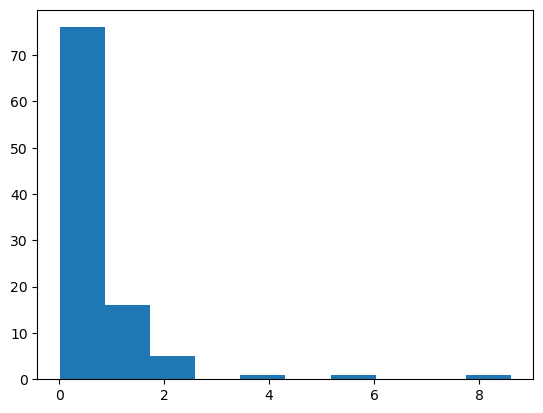

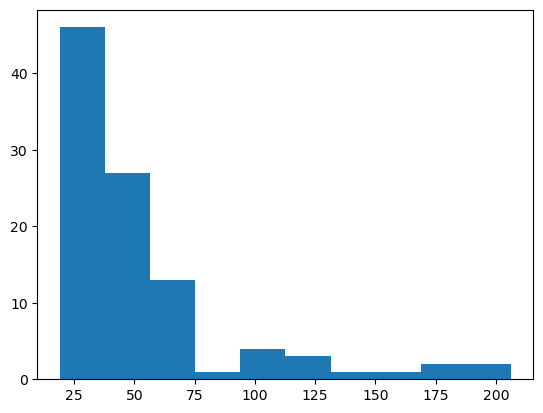

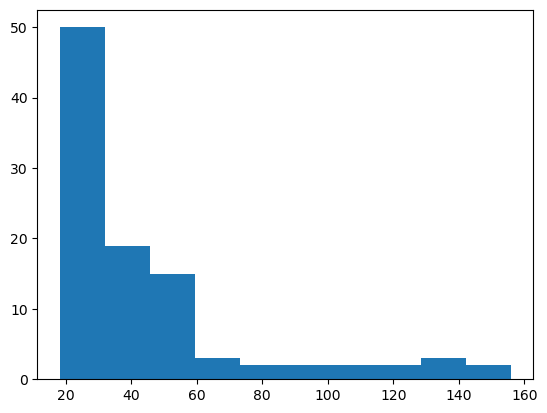

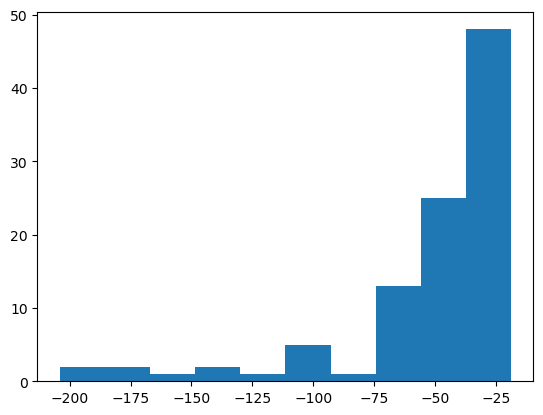

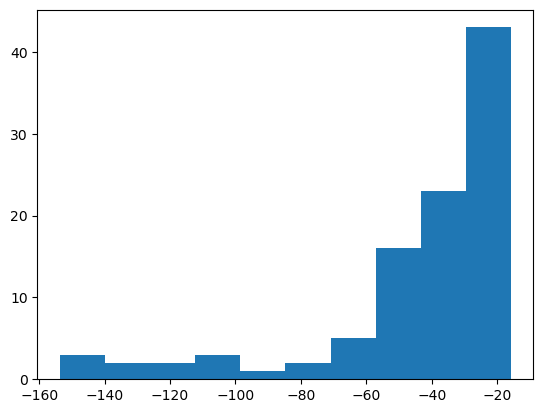

In [6]:
plt.hist(seq_params_df['obj'])
plt.show()
plt.hist(active_params_df['obj'])
plt.show()
plt.hist(passive_params_df['obj'])
plt.show()
plt.hist(seq_params_df['obj']-active_params_df['obj'])
plt.show()
plt.hist(seq_params_df['obj']-passive_params_df['obj'])
plt.show()